In [304]:
%%capture

import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# %load_ext autoreload
# %autoreload 2

PIP_PATH = Path(sys.executable).parent / 'pip3'

!$PIP_PATH install \
    matplotlib \
    plotly \
    seaborn \
    pandas \
    lightgbm \
    xgboost \
    eli5 \
    shap \
    numpy \
    mlxtend \
    statsmodels \
    catboost \
    'imbalanced-learn' \
    'umap-learn[plot]'

In [350]:
# https://www.kaggle.com/c/dont-overfit-ii/discussion/169948
DATA_DIR = Path('.').absolute() / 'older_data'
list(DATA_DIR.glob('*'))

[PosixPath('/Users/v.mamedov/Desktop/masters/1_sem/ml/classification_kaggle/older_data/test.csv'),
 PosixPath('/Users/v.mamedov/Desktop/masters/1_sem/ml/classification_kaggle/older_data/train.csv'),
 PosixPath('/Users/v.mamedov/Desktop/masters/1_sem/ml/classification_kaggle/older_data/sample_submission.csv')]

In [529]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    KFold, 
    cross_val_score, 
    GridSearchCV, 
    RepeatedStratifiedKFold, 
    LeaveOneOut,
    StratifiedShuffleSplit
)
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, RobustScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import (
    GenericUnivariateSelect, 
    SelectPercentile, 
    SelectKBest, 
    f_classif, 
    mutual_info_classif, 
    RFE
)
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

In [352]:
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')
train.shape

(250, 302)

In [631]:
test.shape

(19750, 301)

In [634]:
test.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,0.191,0.732,1.235,-0.867,-0.616,0.340,0.788,-0.044,0.305,-0.819,-0.447,-1.625,-1.005,-0.653,-0.371,1.556,0.754,-0.688,0.061,0.644,0.645,-0.222,-2.174,-0.610,-1.092,0.917,-1.010,-1.021,-0.179,1.732,-0.366,-1.694,1.038,-0.721,0.112,-0.783,0.940,-1.803,1.295,-1.031,0.452,1.198,-0.206,0.051,-1.055,1.740,-0.910,-0.509,-0.987,-1.011,0.718,0.375,0.101,0.137,-1.585,0.532,-1.201,1.210,-0.374,0.300,-0.110,-0.248,1.464,0.056,-0.038,-0.482,0.585,-1.263,0.993,-0.639,-1.337,0.225,1.640,-1.807,-1.983,-0.638,-0.432,1.890,0.506,1.091,-0.635,1.072,0.262,0.418,-1.294,0.868,0.728,0.618,0.540,1.981,-0.246,0.516,-0.373,0.954,-0.854,-1.241,-0.861,0.317,-0.611,-0.179,-1.658,-1.397,-0.988,-0.316,1.808,0.930,1.098,0.997,0.901,1.095,-0.464,2.592,0.846,1.060,-0.676,0.376,0.047,1.265,1.218,1.003,1.219,-0.624,-1.316,0.921,3.472,-1.123,0.037,0.927,-0.695,-0.046,0.270,0.847,-1.072,0.315,2.522,0.376,-0.015,-1.283,-0.650,-0.106,0.747,0.612,-0.838,0.713,0.048,-1.073,0.657,-0.542,-0.269,-0.482,0.329,0.534,0.337,0.118,-0.164,-0.538,-0.285,1.375,1.194,-0.258,-0.298,1.578,-0.488,1.424,1.106,0.363,-2.007,-0.091,0.551,0.388,0.422,0.099,0.378,-1.333,-1.102,2.145,0.745,0.345,-0.904,0.425,-0.273,0.547,-0.184,0.458,0.182,0.592,0.966,0.540,-1.382,0.069,0.131,-0.068,-0.400,0.413,-0.030,0.890,1.000,-0.774,0.340,2.345,2.748,0.774,-0.355,0.574,0.027,1.437,-0.877,0.532,-0.348,0.926,1.308,-0.120,-1.460,0.755,0.426,1.667,-0.264,1.266,0.962,1.285,1.176,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,1.350,-0.414,0.748,2.014,0.858,0.025,1.343,0.784,-0.418,-0.515,0.694,-1.097,0.559,-0.799,-0.936,1.483,1.670,1.403,0.457,-1.564,0.049,0.550,-0.085,-0.561,-0.529,-1.563,-0.781,-0.532,0.375,-0.727,-0.053,-0.383,-0.123,1.573,-0.898,-0.070,0.811,-0.036,0.720,1.691,-0.673,-0.421,-1.665,0.099,0.089,2.032,-1.132,-1.827,-0.017,-1.748,-0.717,2.004,1.216,1.547,1.322,0.481,1.819,-0.809,0.617,-0.763,-0.154,-0.847,-0.981,0.274,-1.856,0.808,-0.599,0.998,-0.286,0.649,0.612,-1.002,1.258,0.149,0.252,1.093,-0.344,0.349,-1.386,-0.518,1.478,-1.261,2.206,-0.053,-1.191,-1.118,0.402,0.786,-0.345,-0.387,0.558,2.202,-2.056,1.502,1.191,-0.404,-2.183,1.559,1.077,-0.659,0.339,1.113,0.286,-0.424,-1.061,-0.748,-1.148,1.705,1.239,-0.912,-0

<a id="de"></a>
## Data exploration

In [620]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 590.0 KB


In [353]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,0.005,1.405,-0.044,-0.458,0.579,2.929,0.833,0.761,0.737,0.669,0.717,-1.542,-1.847,-0.445,1.238,-0.840,-1.891,-1.531,-0.396,-0.927,2.072,0.946,-1.105,0.008,0.933,-1.410,-0.770,1.740,-1.504,-0.391,-1.551,-1.415,-0.974,0.796,-2.464,-1.424,1.230,0.219,0.130,-0.371,-0.930,1.851,1.292,-0.380,1.318,1.146,-0.399,2.227,0.447,0.870,1.420,-1.675,0.019,0.060,0.768,2.563,0.638,1.164,0.407,-1.556,-0.903,1.329,0.452,-0.704,2.218,-1.844,0.158,-1.649,-0.172,-1.167,-1.456,-0.778,0.098,-1.627,0.405,-0.082,-0.797,-0.303,0.710,-0.252,1.920,0.706,-0.915,0.267,-0.607,0.966,-0.337,-2.292,-1.366,-1.085,0.278,0.212,1.260,-1.276,-2.013,-1.101,0.797,0.661,1.232,-0.632,-0.805,1.236,-1.085,-0.067,-0.661,-0.745,1.306,-0.010,-0.475,-0.613,-0.841,-0.837,0.671,2.493,0.689,0.946,0.160,-0.607,-0.775,1.688,0.302,-1.156,-0.718,0.126,0.745,-0.287,-0.565,0.646,-0.119,-0.675,-0.479,-0.191,-0.454,1.314,0.740,0.999,1.242,-0.339,0.403,-1.243,1.365,0.030,-0.475,0.860,0.036,1.313,-0.219,1.078,1.880,-0.317,-0.443,1.876,-0.611,0.892,1.435,-0.226,0.311,0.139,-0.075,1.381,1.716,-2.017,-0.485,1.906,-0.119,0.609,-0.564,0.264,-0.604,-0.733,-2.352,-1.661,0.498,-0.841,0.907,-0.476,0.817,1.372,1.187,0.844,0.028,0.029,-0.808,0.253,1.005,1.413,-0.133,0.655,-0.921,0.231,-1.902,-0.005,-1.730,1.132,-0.194,0.039,1.489,-0.328,0.966,-0.057,-0.181,0.723,-0.313,-0.165,-0.803,0.074,-2.851,-1.021,-0.894,0.967,0.218,-0.692,-0.514,0.754,-1.892,0.203,2.174,-0.755,-1.053,-0.516,-1.109,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,-0.303,-0.307,0.380,0.503,-1.320,0.339,-1.102,-0.947,0.267,0.695,0.167,0.188,-1.082,-0.872,0.660,0.051,0.303,-0.553,-0.771,0.588,0.472,1.315,-0.467,-0.064,1.808,0.633,1.221,1.112,1.133,-0.543,-2.144,0.151,-0.813,1.966,-1.190,0.190,-0.473,0.002,1.195,-0.799,1.117,-0.759,-0.661,0.406,-0.846,-0.035,-1.634,-0.011,0.503,0.610,-1.822,-0.030,1.188,-0.006,-0.279,1.914,0.620,-1.495,1.787,-0.305,0.602,-1.208,0.893,0.379,1.396,0.581,-0.475,-0.056,-0.691,-0.783,-1.485,1.911,-2.400,-2.372,-0.178,1.550,-0.228,0.674,0.987,1.373,-0.373,0.629,0.229,-0.630,-0.175,0.548,0.074,-2.090,-0.625,-1.131,1.111,-0.100,0.574,-0.660,-1.113,0.802,-0.093,1.302,-0.395,0.745,-0.384,0.066,-0.756,0.495,-0.8

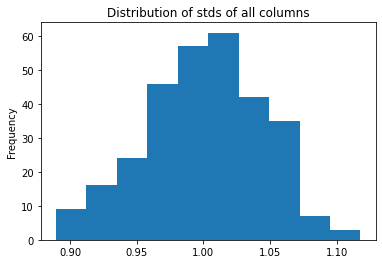

In [354]:
train[train.columns[2:]].std().plot(kind='hist');
plt.title('Distribution of stds of all columns');

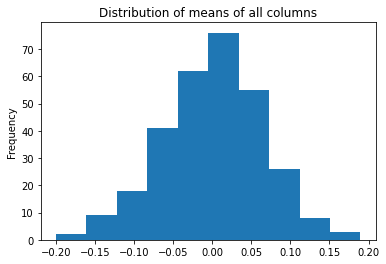

In [355]:
train[train.columns[2:]].mean().plot(kind='hist');
plt.title('Distribution of means of all columns');

In [356]:
# we have no missing values
train.isnull().any().any()

False

Distributions of first 28 columns


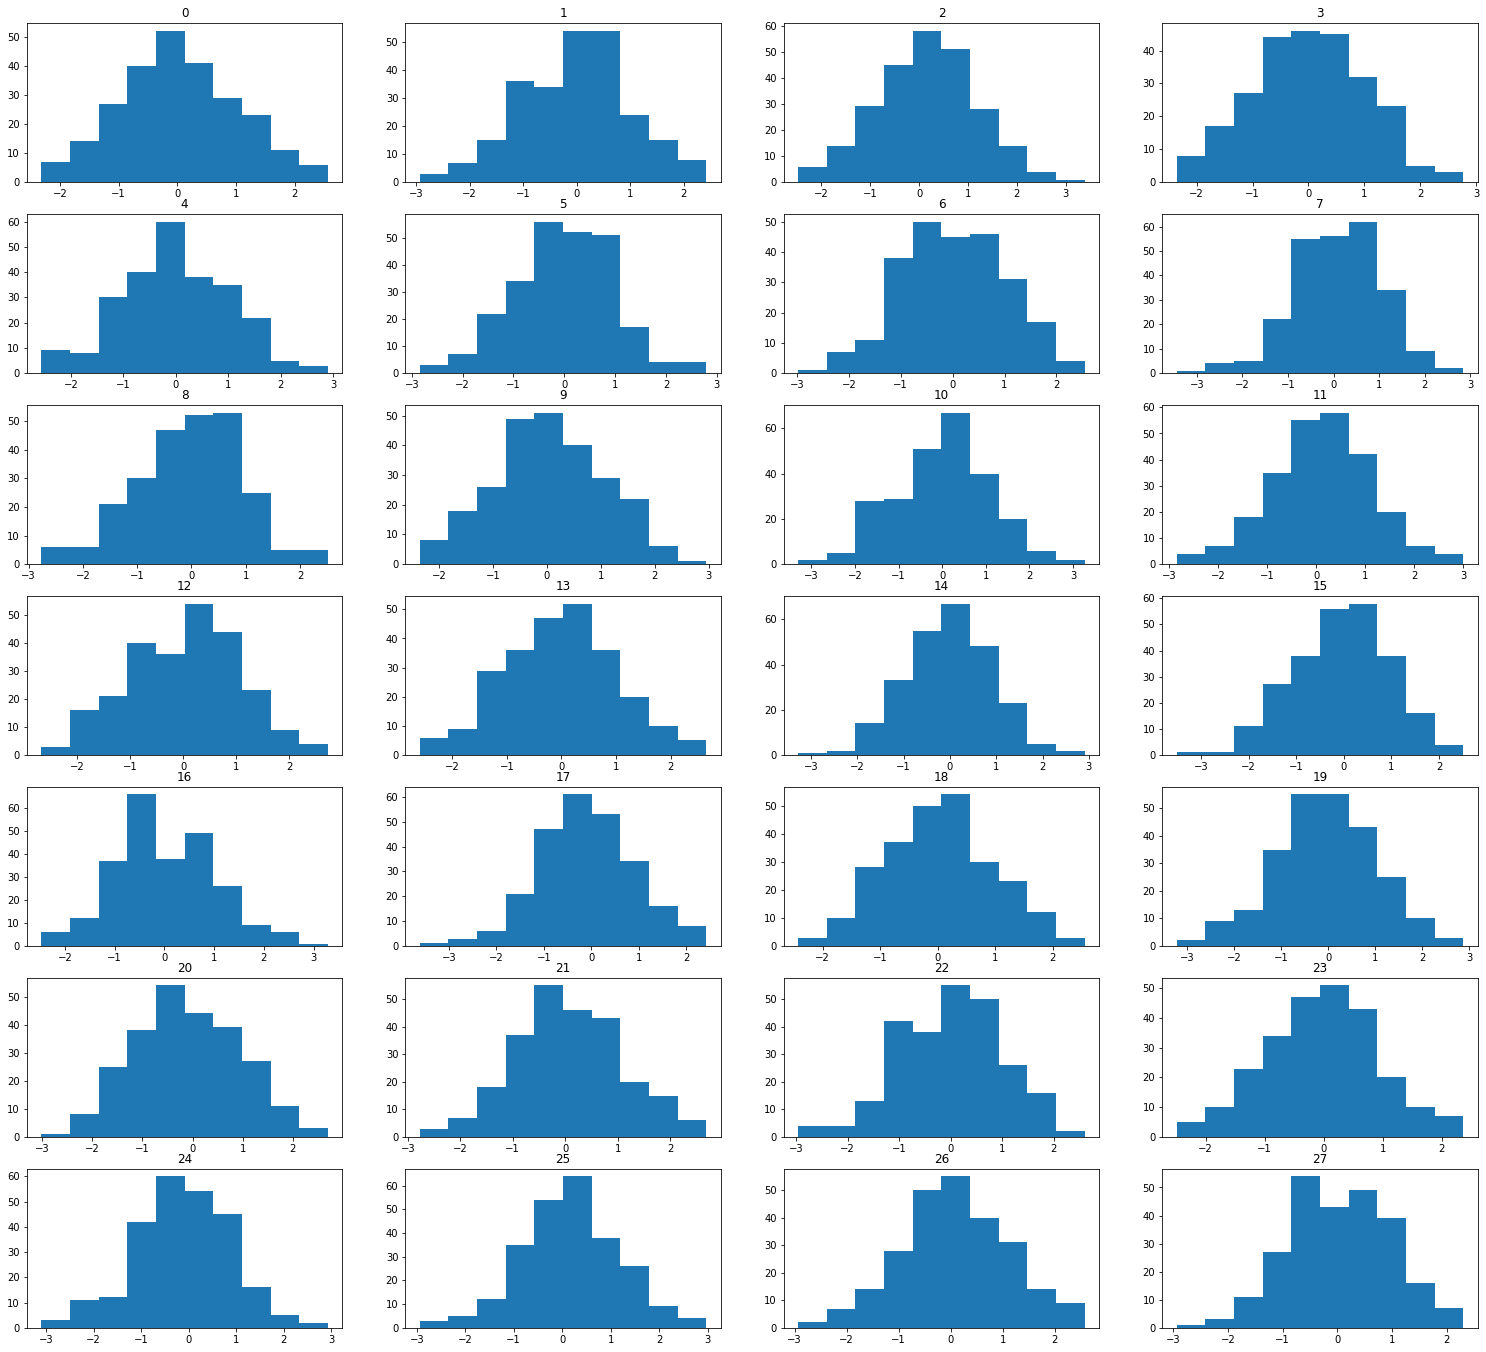

In [357]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [358]:
train['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

From this overview we can see the following things:
* target is binary and has some disbalance: 36% of samples belong to 0 class;
* values in columns are more or less similar;
* columns have std of 1 +/- 0.1 (min and max values are 0.889, 1.117 respectively);
* columns have mean of 0 +/- 0.15 (min and max values are -0.2, 0.1896 respectively);

Let's have a look at correlations now!

In [359]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


We can see that correlations between features are lower that 0.3 and the most correlated feature with target has correlation of 0.37. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

<a id="bm"></a>
## Basic modelling

In [546]:
from sklearn.pipeline import Pipeline

X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 5
loo_folds = LeaveOneOut()
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

random_folds = StratifiedShuffleSplit(n_splits=12, test_size=0.35, train_size=0.65, random_state=42)

scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

X_train_splt,X_val,y_train_splt,y_val = train_test_split(X_train, y_train,
                                           test_size=.25, random_state=42, shuffle=True,stratify=y_train)

X_train = X_train.values
X_test = X_test.values

print(X_train_splt.shape ,X_val.shape, y_train_splt.shape, y_val.shape)

(187, 300) (63, 300) (187,) (63,)


## Viz

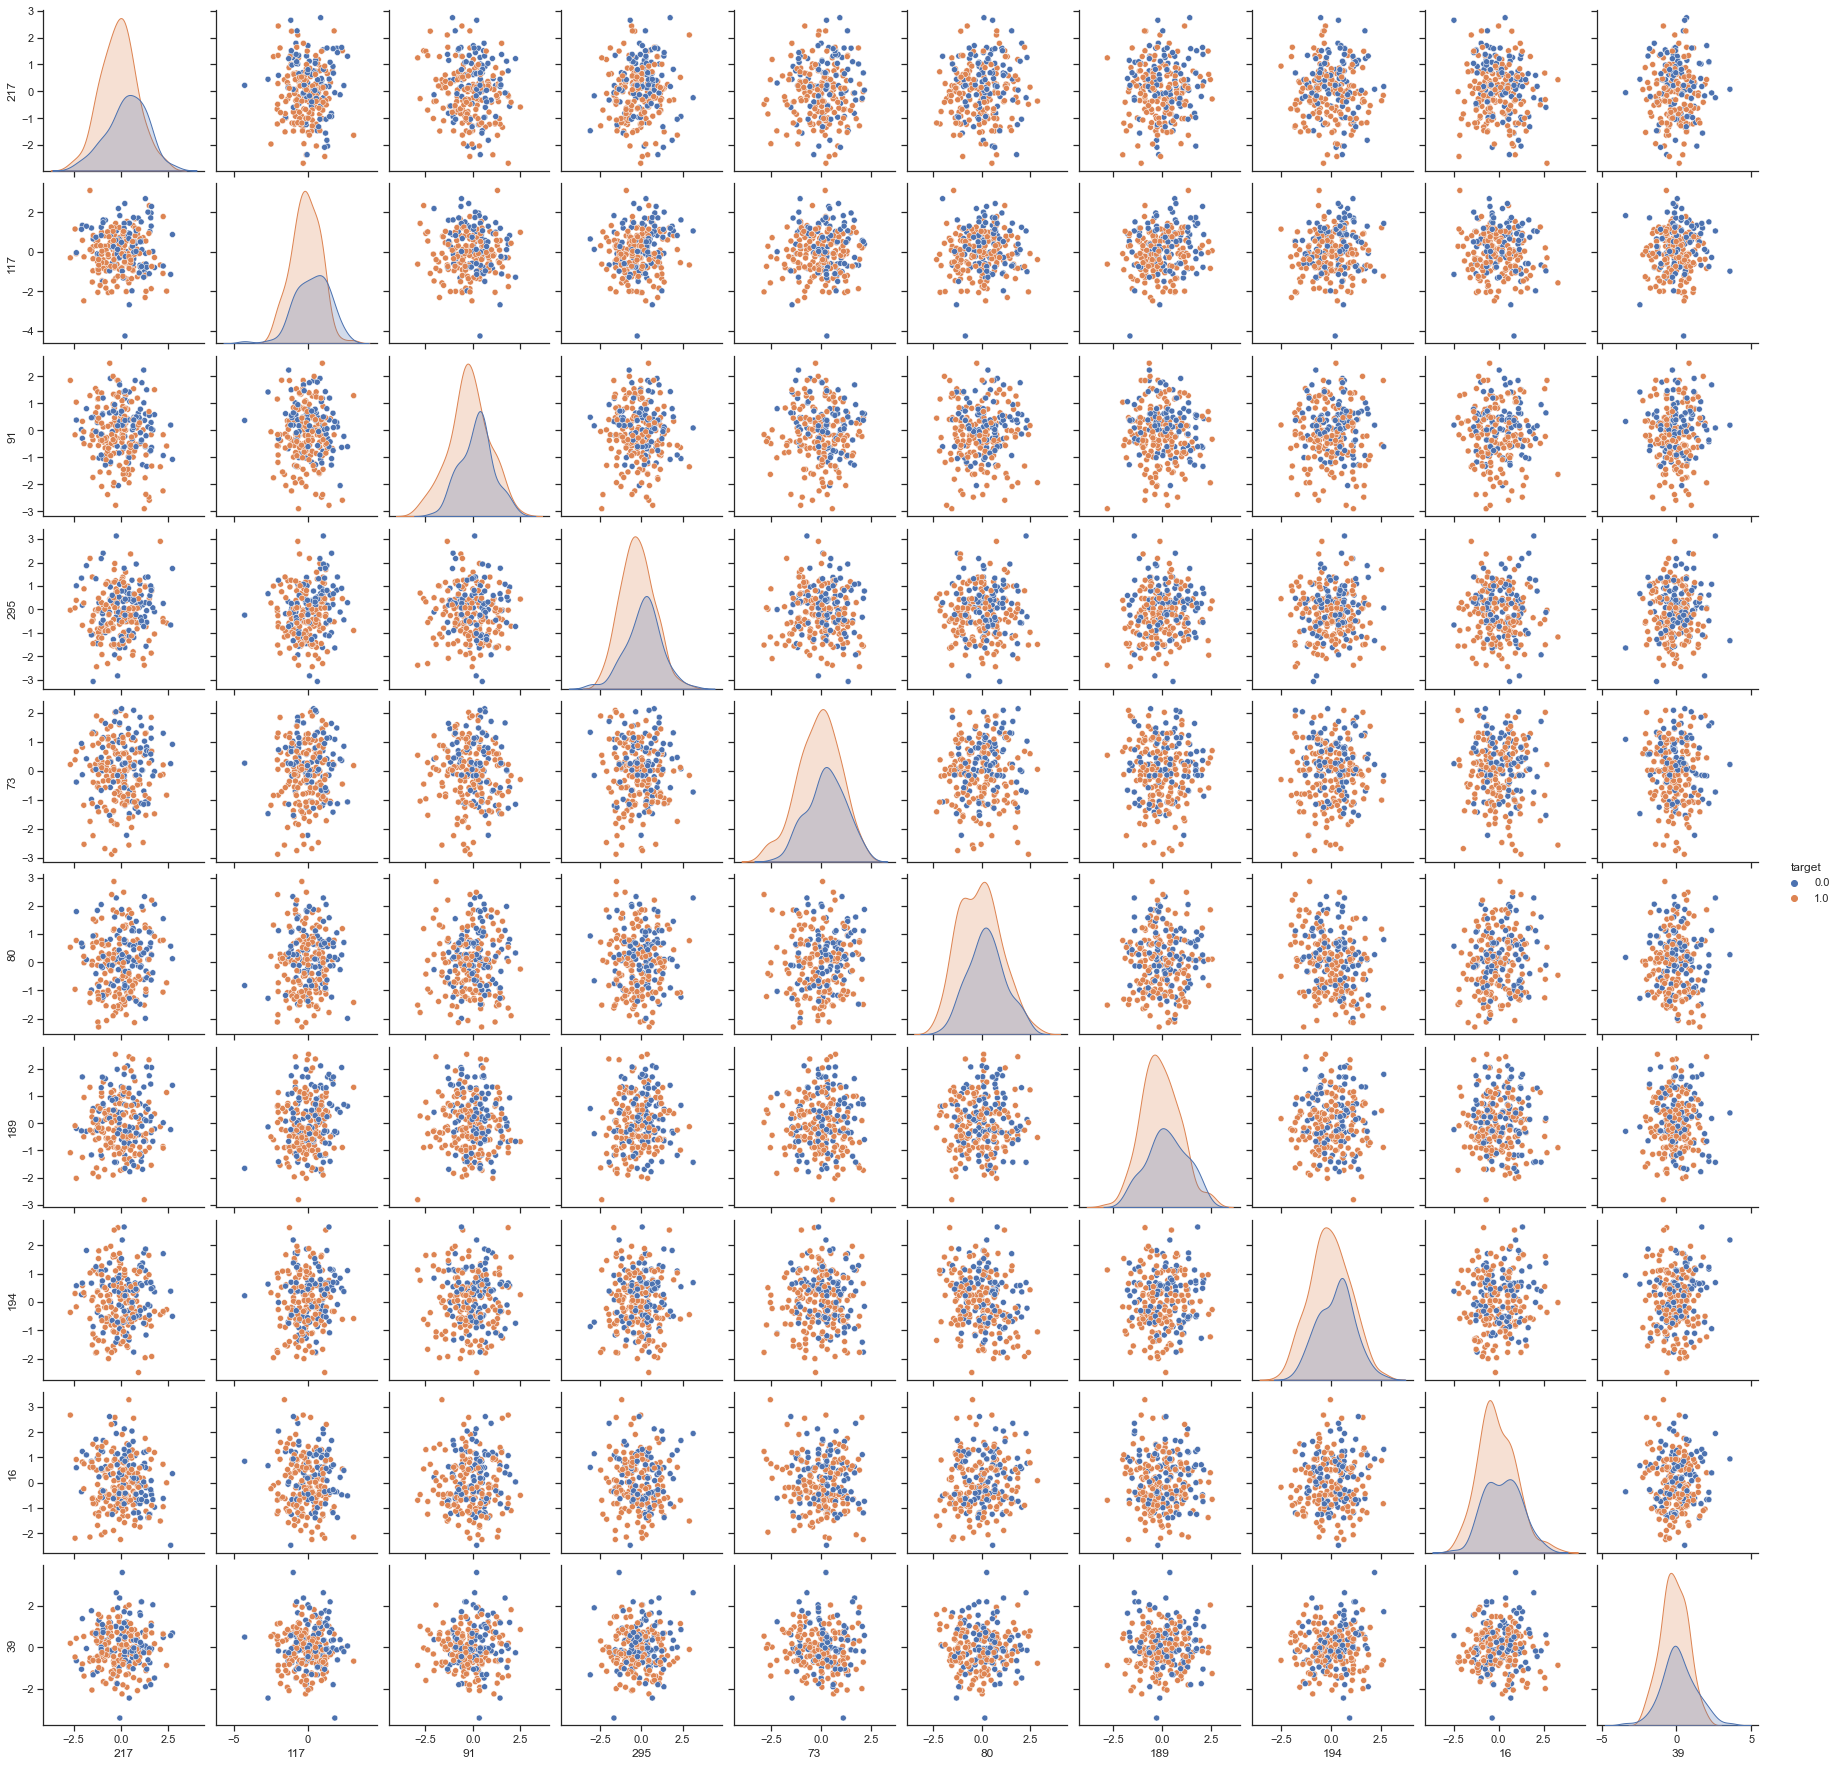

In [583]:
import random
random.seed(42)

most_corr_feats = train.corr()['target'][2:].sort_values().head(10).index.tolist()
dfp = train[["id", "target"]+most_corr_feats]
sns.set(style="ticks")

sns.pairplot(dfp.drop("id",1), hue='target');

<Figure size 432x288 with 0 Axes>

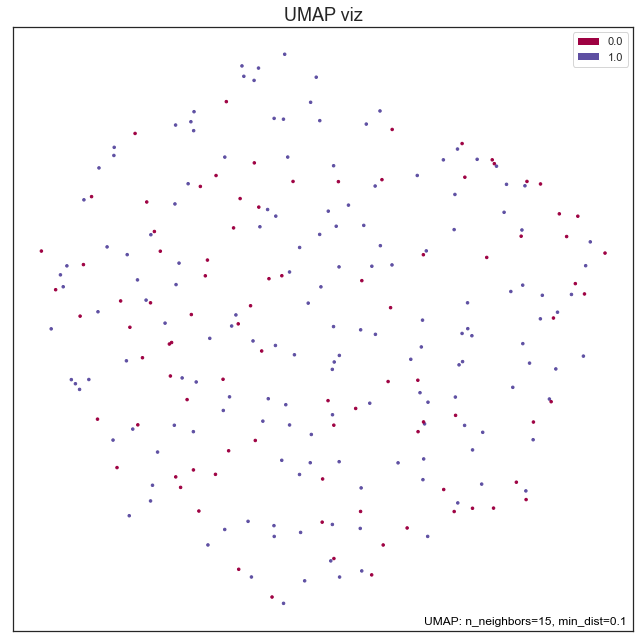

In [623]:
import umap 
import umap.plot

# mapper = umap.UMAP().fit(X_train)
# umap.plot.points(mapper, labels=y_train)


def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(X_train);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=y_train)
    if n_components == 2:
#         ax = fig.add_subplot(111)
#         ax.scatter(u[:,0], u[:,1], c=y_train)
        umap.plot.points(mapper, labels=y_train)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=y_train, s=100)
    plt.title(title, fontsize=18)
    
    
draw_umap(
    n_neighbors=20, 
    min_dist=1, 
    n_components=2, 
#     metric='cosine',
    title='UMAP viz'
)

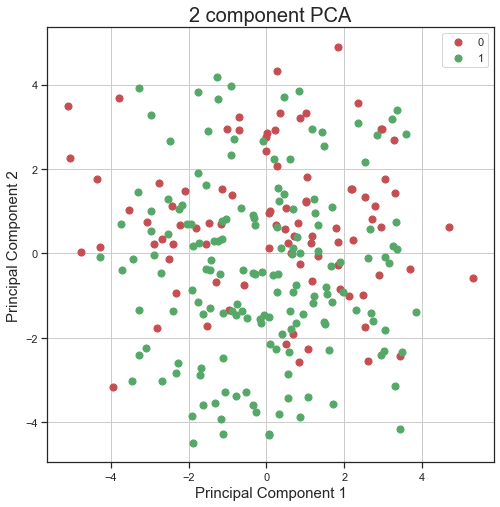

In [626]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)

principalComponents = pca.fit_transform(scaler.fit_transform(X_train))
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = [
                               'principal component 1', 
                               'principal component 2'
                           ])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', ]
for target, color in zip(targets,colors):
    indicesToKeep = y_train == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

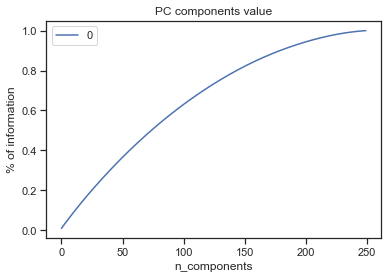

In [630]:
pca = PCA(random_state=42)
pca.fit(scaler.fit_transform(X_train))
tmp = pd.DataFrame(pca.singular_values_)
tmp /= tmp.sum()
tmp.cumsum().plot()
plt.title('PC components value')
plt.xlabel('n_components')
plt.ylabel('% of information')
plt.show()

## Models

In [470]:
def generate_submission_file(prediction, name):
    submission = pd.read_csv(DATA_DIR / 'sample_submission.csv')
    submission['target'] = prediction
    submission.to_csv(DATA_DIR / f'{name}.csv', index=False)

In [527]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


def print_metrics(pipeline,
                  X_train=X_train_splt, X_val=X_val,
                  y_train=y_train_splt, y_val=y_val):

    perdt = pipeline.predict(X_train)
    perdv = pipeline.predict(X_val)
    cmt = confusion_matrix(y_train, perdt)
    cmv = confusion_matrix(y_val, perdv)

#     print('\nTrain Aaccuracy =',accuracy_score(y_train, perdt) ,
#           ' \nValidation Aaccuracy =',accuracy_score(y_val, perdv))
    print('---'*6)
    print('AUC train: ',roc_auc_score(y_train, perdt) )
    print('AUC Val: ',roc_auc_score(y_val,perdv) )
    print()
    print('MSE train: ', mean_squared_error(y_train, perdt))
    print('MSE Val: ',   mean_squared_error(y_val, perdv))
    print()
    print('MAE train: ', mean_absolute_error(y_train, perdt))
    print('MAE Val: ',   mean_absolute_error(y_val, perdv))
    print()    
    print('COS train: ', cosine_similarity(
        y_train.values.reshape(1, -1), perdt.reshape(1, -1))[0][0])
    print('COS Val: ',   cosine_similarity(
        y_val.values.reshape(1, -1), perdv.reshape(1, -1))[0][0])
    print()    
    print('Euclidean train: ', euclidean_distances(
        y_train.values.reshape(1, -1), perdt.reshape(1, -1))[0][0])
    print('Euclidean Val: ',   euclidean_distances(
        y_val.values.reshape(1, -1), perdv.reshape(1, -1))[0][0])
    print()    
    print('R2 train: ', r2_score(y_train, perdt))
    print('R2 Val: ',   r2_score(y_val, perdv))
    print()
    print('Confusion matrix train: \n',cmt)
    print('Confusion matrix val: \n',cmv)
    print('---'*6)


In [599]:
def train_model(X, X_test, y, params=None, folds=random_folds, 
                model_type='sklearn', 
                averaging='usual',
                model=None,
                verbose=True,
               ):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
            
        if model_type == 'sklearn':
            model = model
            if params:
                model.set_params(**params)
#             print(model.get_params())
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            
            if verbose:
                print_metrics(
                    model,
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_valid,
                    y_val=y_valid,
                )
            score = roc_auc_score(y_valid, y_pred_valid)
#             print(f'Fold {fold_n}. AUC: {score:.4f}.')
#             print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
                    
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
    
    prediction /= n_fold
    if verbose: 
        print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    return oof, prediction, scores

# Logistic Regression

In [518]:
# ?linear_model.LogisticRegression

In [519]:
import sys
import os
import warnings

# https://coderoad.ru/53784971/%D0%9A%D0%B0%D0%BA-%D0%BE%D1%82%D0%BA%D0%BB%D1%8E%D1%87%D0%B8%D1%82%D1%8C-ConvergenceWarning-%D1%81-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E-sklearn
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [610]:
import warnings
from sklearn.exceptions import ConvergenceWarning

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regression', linear_model.LogisticRegression(
        random_state=42, 
        max_iter=500, 
        class_weight='balanced')
    )
])


def add_noise(np_array, noise_std=0.01):
#     add a bit of noise to reduce overfitting
    return np_array + np.random.normal(0, noise_std, np_array.shape)


param_grid = [
#      LASSO
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['liblinear'],
    'regression__penalty' : ['l1'],
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__C' : np.logspace(1, 2, 10),
    }, 
#     RIDGE
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['liblinear'],
    'regression__penalty' : ['l2'],
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__C' : np.logspace(0.5, 2, 10),
    }, 
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['saga'],
    'regression__penalty' : ['elasticnet'],
    'regression__C' : np.logspace(0.5, 2, 10),
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__l1_ratio': np.logspace(-1, 0, 5)
    }
]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    verbose=1,
    cv=n_fold, 
    scoring='roc_auc'
)

grid_search.fit(add_noise(X_train), y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
best_params = grid_search.best_params_
_, prediction_lr, scores_lr = train_model(add_noise(X_train), X_test, y_train, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True,
                                            folds=random_folds)
generate_submission_file(prediction_lr, 'pipeline_lr_v4')

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits
Best score: 0.803125
Best parameters: {'regression__C': 10.0, 'regression__penalty': 'l1', 'regression__solver': 'liblinear', 'regression__tol': 0.004641588833612777, 'scaler': RobustScaler()}
------------------
AUC train:  1.0
AUC Val:  0.6495535714285714

MSE train:  0.0
MSE Val:  0.3181818181818182

MAE train:  0.0
MAE Val:  0.3181818181818182

COS train:  1.0000000000000002
COS Val:  0.754502086819366

Euclidean train:  0.0
Euclidean Val:  5.291502622129181

R2 train:  1.0
R2 Val:  -0.3749999999999998

Confusion matrix train: 
 [[ 58   0]
 [  0 104]]
Confusion matrix val: 
 [[17 15]
 [13 43]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.6852678571428572

MSE train:  0.0
MSE Val:  0.3068181818181818

MAE train:  0.0
MAE Val:  0.3068181818181818

COS train:  1.0000000000000002
COS Val:  0.7484811885651197

Euclidean train:  0.0
Euclidean Val:  5.196152422706632

R2 train:  1.0
R2 Val:  -0.3258928571

# SVM

In [436]:
# ?SVC

In [668]:
from sklearn.svm import SVC

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True))
])

base_params = {
    'svm__class_weight' : ['balanced', {0:2, 1:1}],
    'svm__C': np.logspace(-1, 2, 10),
    'scaler': [
               StandardScaler(),  
               RobustScaler(),
#                KBinsDiscretizer(n_bins=25, strategy='quantile')
              ],
}

param_grid = [{
    'svm__kernel': ['linear',],
    **base_params
}, 
    {
    'svm__kernel': [ 'rbf',],
    'svm__gamma': np.logspace(-4, 0, 5),
    **base_params
}, 
    {
    'svm__kernel': ['sigmoid'],
    'svm__gamma': np.logspace(-4, 0, 5),
    'svm__coef0': np.logspace(-3, 1, 5),
    **base_params
}, 
    {

    'svm__kernel': [ 'poly'],
    'svm__degree': [3,5],
    'svm__coef0': np.logspace(-3, 0, 5),
    **base_params
}]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    verbose=1,
    cv=n_fold, 
    scoring='roc_auc'
)

grid_search.fit(add_noise(X_train), y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

# print_metrics(pipeline, grid_search.best_params_)

best_params = grid_search.best_params_
_, predictions_svc, scores_svc = train_model(add_noise(X_train), X_test, y_train, 
                                     params=best_params, 
                                     model_type='sklearn', 
                                     model=pipeline, 
                                     verbose=True)
generate_submission_file(predictions_svc, 'pipeline_svc')

Fitting 5 folds for each of 1640 candidates, totalling 8200 fits
Best score: 0.7597222222222223
Best parameters: {'scaler': RobustScaler(), 'svm__C': 21.54434690031882, 'svm__class_weight': 'balanced', 'svm__coef0': 1.0, 'svm__gamma': 0.01, 'svm__kernel': 'sigmoid'}
------------------
AUC train:  0.6208554376657826
AUC Val:  0.6294642857142857

MSE train:  0.3888888888888889
MSE Val:  0.3522727272727273

MAE train:  0.3888888888888889
MAE Val:  0.3522727272727273

COS train:  0.6646157913016237
COS Val:  0.7158675207589935

Euclidean train:  7.937253933193772
Euclidean Val:  5.5677643628300215

R2 train:  -0.6919761273209548
R2 Val:  -0.5223214285714284

Confusion matrix train: 
 [[38 20]
 [43 61]]
Confusion matrix val: 
 [[18 14]
 [17 39]]
------------------
------------------
AUC train:  0.6132294429708223
AUC Val:  0.6272321428571428

MSE train:  0.3888888888888889
MSE Val:  0.3977272727272727

MAE train:  0.3888888888888889
MAE Val:  0.3977272727272727

COS train:  0.67006111695313

# Forest

In [245]:
# ?RandomForestClassifier

In [674]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier(random_state=42))
])

base_params = {
    'forest__class_weight' : [
        'balanced', 'balanced_subsample'],
    'forest__n_estimators': [150],
    'forest__criterion': ["entropy"],
    'forest__max_depth': [4, 5],
    'forest__max_samples': [15, 20, 30, None],
    'forest__ccp_alpha': [0.04, 0.1, 0.18],
    'forest__max_features': [3, 4, 5],
    'forest__max_leaf_nodes': [4, 6, 8, 10]
}


param_grid = [{
    **base_params
}]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    cv=n_fold, 
    verbose=1,
    scoring='roc_auc'
)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

best_params = grid_search.best_params_
_, predictions_forest, scores_forest = train_model(X_train, X_test, y_train, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True)
generate_submission_file(predictions_forest, 'pipeline_forest')

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best score: 0.7114583333333334
Best parameters: {'forest__ccp_alpha': 0.1, 'forest__class_weight': 'balanced_subsample', 'forest__criterion': 'entropy', 'forest__max_depth': 4, 'forest__max_features': 5, 'forest__max_leaf_nodes': 6, 'forest__max_samples': None, 'forest__n_estimators': 150}
------------------
AUC train:  0.8829575596816975
AUC Val:  0.5758928571428572

MSE train:  0.1111111111111111
MSE Val:  0.3522727272727273

MAE train:  0.1111111111111111
MAE Val:  0.3522727272727273

COS train:  0.9126643739222255
COS Val:  0.7561001062031496

Euclidean train:  4.242640687119285
Euclidean Val:  5.5677643628300215

R2 train:  0.51657824933687
R2 Val:  -0.5223214285714284

Confusion matrix train: 
 [[50  8]
 [10 94]]
Confusion matrix val: 
 [[10 22]
 [ 9 47]]
------------------
------------------
AUC train:  0.9376657824933687
AUC Val:  0.65625

MSE train:  0.05555555555555555
MSE Val:  0.3181818181818182

MAE train:  0.

## RandomUnderSampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [617]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier(random_state=42))
])

base_params = {
    'forest__class_weight' : [None, 'balanced_subsample'],
    'forest__n_estimators': [20, 50, 150],
    'forest__criterion': ["entropy"],
    'forest__max_depth': [4, 5],
    'forest__max_samples': [15, 20, 30, None],
    'forest__ccp_alpha': [0.1, 0.18],
    'forest__max_features': [3, 4, 5],
    'forest__max_leaf_nodes': [4, 6, 8, 10]
}

param_grid = [{
    **base_params
}]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    cv=n_fold, 
    verbose=1,
#     scoring='roc_auc',
    scoring='accuracy'
)

grid_search.fit(X_resampled, y_resampled)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

best_params = grid_search.best_params_
_, predictions_forest_under_sample, scores_forest_under_sample = train_model(
    X_resampled, X_test, y_resampled, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True)

generate_submission_file(predictions_forest_under_sample, 'pipeline_forest_under_sample')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best score: 0.6833333333333333
Best parameters: {'forest__ccp_alpha': 0.1, 'forest__class_weight': 'balanced_subsample', 'forest__criterion': 'entropy', 'forest__max_depth': 5, 'forest__max_features': 5, 'forest__max_leaf_nodes': 6, 'forest__max_samples': None, 'forest__n_estimators': 150}
------------------
AUC train:  0.9915254237288136
AUC Val:  0.6517137096774194

MSE train:  0.008547008547008548
MSE Val:  0.3492063492063492

MAE train:  0.008547008547008548
MAE Val:  0.3492063492063492

COS train:  0.9914892069294687
COS Val:  0.6678944147908077

Euclidean train:  1.0
Euclidean Val:  4.69041575982343

R2 train:  0.9658094681472823
R2 Val:  -0.3971774193548385

Confusion matrix train: 
 [[58  0]
 [ 1 58]]
Confusion matrix val: 
 [[19 13]
 [ 9 22]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.6668346774193549

MSE train:  0.0
MSE Val:  0.3333333333333333

MAE train:  0.0
MAE Val:  0.333333333333333

# LR

In [638]:
import warnings
from sklearn.exceptions import ConvergenceWarning

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regression', linear_model.LogisticRegression(
        random_state=42, 
        max_iter=500, 
        class_weight='balanced')
    )
])


def add_noise(np_array, noise_std=0.01):
#     add a bit of noise to reduce overfitting
    return np_array + np.random.normal(0, noise_std, np_array.shape)


param_grid = [
#      LASSO
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['liblinear'],
    'regression__penalty' : ['l1'],
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__C' : np.logspace(1, 2, 10),
    }, 
#     RIDGE
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['liblinear'],
    'regression__penalty' : ['l2'],
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__C' : np.logspace(0.5, 2, 10),
    }, 
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['saga'],
    'regression__penalty' : ['elasticnet'],
    'regression__C' : np.logspace(0.5, 2, 10),
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__l1_ratio': np.logspace(-1, 0, 5)
    }
]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    verbose=1,
    cv=n_fold, 
    scoring='roc_auc'
)

grid_search.fit(add_noise(X_resampled), y_resampled)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
best_params = grid_search.best_params_
_, prediction_lr_under_sample, scores_lr_under_sample = train_model(
    add_noise(X_resampled), X_test, y_resampled, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True,
                                            folds=random_folds)
generate_submission_file(prediction_lr_under_sample, 'pipeline_lr_under_sample')

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits
Best score: 0.715432098765432
Best parameters: {'regression__C': 77.4263682681127, 'regression__penalty': 'l1', 'regression__solver': 'liblinear', 'regression__tol': 0.0021544346900318843, 'scaler': StandardScaler()}
------------------
AUC train:  1.0
AUC Val:  0.6335685483870968

MSE train:  0.0
MSE Val:  0.36507936507936506

MAE train:  0.0
MAE Val:  0.36507936507936506

COS train:  1.0000000000000002
COS Val:  0.598799460624895

Euclidean train:  0.0
Euclidean Val:  4.795831523312719

R2 train:  1.0
R2 Val:  -0.4606854838709675

Confusion matrix train: 
 [[58  0]
 [ 0 59]]
Confusion matrix val: 
 [[23  9]
 [14 17]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.7283266129032259

MSE train:  0.0
MSE Val:  0.2698412698412698

MAE train:  0.0
MAE Val:  0.2698412698412698

COS train:  0.9999999999999999
COS Val:  0.7642869980476023

Euclidean train:  0.0
Euclidean Val:  4.123105625617661

R2 train:  1.0


# SVC

In [652]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True))
])

base_params = {
    'svm__class_weight' : [None],
    'svm__C': np.logspace(1, 2, 10),
    'scaler': [
               StandardScaler(),  
               RobustScaler(),
#                KBinsDiscretizer(n_bins=25, strategy='quantile')
              ],
}

param_grid = [{
    'svm__kernel': ['linear',],
    **base_params
}, 
{
    'svm__kernel': [ 'rbf',],
    'svm__gamma': np.logspace(-4, 0, 5),
    **base_params
}, 
    {
    'svm__kernel': ['sigmoid'],
    'svm__gamma': np.logspace(-4, 0, 5),
    'svm__coef0': np.logspace(-3, 2, 10),
    **base_params
}, 
    {

    'svm__kernel': [ 'poly'],
    'svm__degree': [3,5],
    'svm__coef0': np.logspace(-3, 0, 5),
    **base_params
}
]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    verbose=1,
    cv=n_fold, 
    scoring='roc_auc'
)

grid_search.fit(X_resampled, y_resampled)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

# print_metrics(pipeline, grid_search.best_params_)

best_params = grid_search.best_params_

_, predictions_svc_under_sample, scores_svc_under_sample = train_model(
                        X_resampled, X_test, y_resampled, 
                                     params=best_params, 
                                     model_type='sklearn', 
                                     model=pipeline, 
                                     verbose=True)
generate_submission_file(predictions_svc_under_sample, 'pipeline_svc_under_sample')

Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Best score: 0.7179012345679012
Best parameters: {'scaler': StandardScaler(), 'svm__C': 10.0, 'svm__class_weight': None, 'svm__coef0': 0.001, 'svm__degree': 3, 'svm__kernel': 'poly'}
------------------
AUC train:  1.0
AUC Val:  0.5252016129032258

MSE train:  0.0
MSE Val:  0.47619047619047616

MAE train:  0.0
MAE Val:  0.47619047619047616

COS train:  1.0000000000000002
COS Val:  0.561011665589618

Euclidean train:  0.0
Euclidean Val:  5.477225575051661

R2 train:  1.0
R2 Val:  -0.9052419354838706

Confusion matrix train: 
 [[58  0]
 [ 0 59]]
Confusion matrix val: 
 [[14 18]
 [12 19]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.5

MSE train:  0.0
MSE Val:  0.5079365079365079

MAE train:  0.0
MAE Val:  0.5079365079365079

COS train:  0.9999999999999999
COS Val:  0.0

Euclidean train:  0.0
Euclidean Val:  5.656854249492381

R2 train:  1.0
R2 Val:  -1.0322580645161286

Confusion matrix train: 
 [[59  0]
 

<a id="mlextend"></a>
# mutual_info_classif

In [456]:
from sklearn.metrics import roc_auc_score, SCORERS ,auc, confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.decomposition import PCA    
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn import svm

In [457]:
mi = mutual_info_classif(X_train, y_train, random_state=42)

In [458]:
selectedFeature  =  np.array( mi > 0.02)
selected_cols = train.drop(['id', 'target'], axis=1).columns[selectedFeature]
print('number of selected columns',selectedFeature.sum())
print('number of selected columns', selected_cols)

number of selected columns 78
number of selected columns Index(['2', '13', '15', '17', '18', '20', '32', '33', '36', '38', '39', '44',
       '47', '48', '52', '53', '56', '58', '61', '65', '66', '68', '70', '80',
       '91', '92', '96', '98', '106', '107', '112', '114', '119', '120', '122',
       '130', '131', '133', '138', '141', '145', '146', '152', '165', '167',
       '171', '175', '176', '178', '179', '183', '188', '189', '193', '194',
       '201', '205', '212', '215', '216', '217', '219', '225', '230', '231',
       '232', '235', '236', '239', '247', '251', '259', '267', '276', '279',
       '280', '289', '298'],
      dtype='object')


In [459]:
selected_features_train_X = train.drop(['id', 'target'], axis=1)[selected_cols].values
selected_features_test_X = test.drop(['id'], axis=1)[selected_cols].values

## RandomForest

In [669]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier(random_state=42))
])

base_params = {
    'forest__class_weight' : [None, 'balanced_subsample'],
    'forest__n_estimators': [20, 50, 150],
    'forest__criterion': ["entropy"],
    'forest__max_depth': [4, 5],
    'forest__max_samples': [15, 20, 30, None],
    'forest__ccp_alpha': [0.1, 0.18],
    'forest__max_features': [3, 4, 5],
    'forest__max_leaf_nodes': [4, 6, 8, 10]
}

param_grid = [{
    **base_params
}]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    cv=n_fold, 
    verbose=1,
#     scoring='roc_auc',
    scoring='accuracy'
)

grid_search.fit(add_noise(selected_features_train_X), y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

best_params = grid_search.best_params_
_, predictions_forest_mutual_info, scores_forest_mutual_info = train_model(
    add_noise(selected_features_train_X), selected_features_test_X, y_train, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True)

generate_submission_file(predictions_forest_mutual_info, 'pipeline_forest_mutual_info')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best score: 0.708
Best parameters: {'forest__ccp_alpha': 0.1, 'forest__class_weight': 'balanced_subsample', 'forest__criterion': 'entropy', 'forest__max_depth': 4, 'forest__max_features': 3, 'forest__max_leaf_nodes': 6, 'forest__max_samples': None, 'forest__n_estimators': 150}
------------------
AUC train:  0.8887599469496021
AUC Val:  0.71875

MSE train:  0.09876543209876543
MSE Val:  0.23863636363636365

MAE train:  0.09876543209876543
MAE Val:  0.23863636363636365

COS train:  0.9238514227833445
COS Val:  0.8249579113843055

Euclidean train:  4.0
Euclidean Val:  4.58257569495584

R2 train:  0.5702917771883289
R2 Val:  -0.031249999999999778

Confusion matrix train: 
 [[49  9]
 [ 7 97]]
Confusion matrix val: 
 [[18 14]
 [ 7 49]]
------------------
------------------
AUC train:  0.8715185676392573
AUC Val:  0.6919642857142857

MSE train:  0.1111111111111111
MSE Val:  0.2727272727272727

MAE train:  0.1111111111111111
MAE 

## Logistic Regression

In [614]:
import warnings
from sklearn.exceptions import ConvergenceWarning

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regression', linear_model.LogisticRegression(
        random_state=42, 
        max_iter=500, 
        class_weight='balanced')
    )
])


param_grid = [
#      LASSO
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['liblinear'],
    'regression__penalty' : ['l1'],
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__C' : np.logspace(1, 2, 10),
    }, 
#     RIDGE
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['liblinear'],
    'regression__penalty' : ['l2'],
    'regression__tol' : np.logspace(-3, 0, 10),
    'regression__C' : np.logspace(0.5, 2, 10),
    }, 
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'regression__solver': ['saga'],
    'regression__penalty' : ['elasticnet'],
    'regression__C' : np.logspace(0.1, 1, 10),
    'regression__tol' : np.logspace(-3, 0, 15),
    'regression__l1_ratio': np.logspace(-1, 0, 10)
    }
]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    verbose=1,
    cv=n_fold, 
    scoring='roc_auc'
)

grid_search.fit(add_noise(selected_features_train_X), y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


best_params = grid_search.best_params_
_, prediction_lr_mutual_info, scores_lr_mutual_info = train_model(add_noise(selected_features_train_X),
                                     selected_features_test_X, y_train, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True,
                                            folds=random_folds
                                    )

generate_submission_file(prediction_lr_mutual_info, 'pipeline_lr_mutual_info_v4')

Fitting 5 folds for each of 3400 candidates, totalling 17000 fits
Best score: 0.7819444444444443
Best parameters: {'regression__C': 1.2589254117941673, 'regression__l1_ratio': 0.1, 'regression__penalty': 'elasticnet', 'regression__solver': 'saga', 'regression__tol': 0.22758459260747887, 'scaler': StandardScaler()}
------------------
AUC train:  0.8741710875331564
AUC Val:  0.7075892857142857

MSE train:  0.1419753086419753
MSE Val:  0.26136363636363635

MAE train:  0.1419753086419753
MAE Val:  0.26136363636363635

COS train:  0.8835014217964425
COS Val:  0.8002723507351042

Euclidean train:  4.795831523312719
Euclidean Val:  4.795831523312719

R2 train:  0.3822944297082228
R2 Val:  -0.1294642857142856

Confusion matrix train: 
 [[54  4]
 [19 85]]
Confusion matrix val: 
 [[19 13]
 [10 46]]
------------------
------------------
AUC train:  0.9116379310344828
AUC Val:  0.7232142857142857

MSE train:  0.09876543209876543
MSE Val:  0.2840909090909091

MAE train:  0.09876543209876543
MAE Val

In [659]:
best_params = grid_search.best_params_
_, _, _ = train_model(add_noise(selected_features_train_X),
                                     selected_features_test_X, y_train, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True,
                                            folds=KFold(n_splits=2)
                                    )

------------------
AUC train:  1.0
AUC Val:  0.5633696309739867

MSE train:  0.0
MSE Val:  0.288

MAE train:  0.0
MAE Val:  0.288

COS train:  1.0000000000000004
COS Val:  0.8270180805175907

Euclidean train:  0.0
Euclidean Val:  6.0

R2 train:  1.0
R2 Val:  -0.36116152450090766

Confusion matrix train: 
 [[52  0]
 [ 0 73]]
Confusion matrix val: 
 [[ 7 31]
 [ 5 82]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.5

MSE train:  0.0
MSE Val:  0.416

MAE train:  0.0
MAE Val:  0.416

COS train:  0.9999999999999999
COS Val:  0.7641989269817124

Euclidean train:  0.0
Euclidean Val:  7.211102550927978

R2 train:  1.0
R2 Val:  -0.7123287671232881

Confusion matrix train: 
 [[38  0]
 [ 0 87]]
Confusion matrix val: 
 [[ 0 52]
 [ 0 73]]
------------------
CV mean score: 0.5317, std: 0.0317.


## SVC

In [616]:
from sklearn.svm import SVC
default_params = dict(
    class_weight='balanced',
    kernel='linear'
)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True))
])

base_params = {
    'svm__class_weight' : ['balanced'],
    'svm__C': np.logspace(-3, 0, 10),
}

param_grid = [{
    'svm__kernel': ['linear',],
    'svm__class_weight' : ['balanced'],
    'svm__C': np.logspace(-3, 0, 10),
}, {
    'svm__kernel': [ 'rbf', 'sigmoid'],
    'svm__gamma': np.logspace(-4, 0, 10),
    'svm__class_weight' : ['balanced'],
    'svm__C': np.logspace(-3, 0, 10),
}, {
    'svm__kernel': [ 'poly',],
    'svm__degree': [2,3,],
    'svm__coef0': np.logspace(-3, 0, 10),
    'svm__class_weight' : ['balanced'],
    'svm__C': np.logspace(-3, 0, 10),
}]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    refit=True,
    n_jobs=-1,
    cv=n_fold, 
    scoring='roc_auc',
    verbose=1,
    return_train_score=True
)


grid_search.fit(selected_features_train_X, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


best_params = grid_search.best_params_
_, predictions_svc_mutual_info, scores_svc_mutual_info = train_model(
                                            selected_features_train_X, 
                                            selected_features_test_X, y_train, 
                                            params=best_params, 
                                            model_type='sklearn', 
                                            model=pipeline, verbose=True)
generate_submission_file(predictions_svc_mutual_info, 'pipeline_svc_mutual_info')

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Best score: 0.7871527777777777
Best parameters: {'svm__C': 0.0021544346900318843, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear'}
------------------
AUC train:  0.8322281167108755
AUC Val:  0.6897321428571428

MSE train:  0.1419753086419753
MSE Val:  0.25

MAE train:  0.1419753086419753
MAE Val:  0.25

COS train:  0.893496949259928
COS Val:  0.8264597475290097

Euclidean train:  4.795831523312719
Euclidean Val:  4.69041575982343

R2 train:  0.3822944297082228
R2 Val:  -0.0803571428571428

Confusion matrix train: 
 [[43 15]
 [ 8 96]]
Confusion matrix val: 
 [[15 17]
 [ 5 51]]
------------------
------------------
AUC train:  0.8609084880636604
AUC Val:  0.7522321428571428

MSE train:  0.12962962962962962
MSE Val:  0.23863636363636365

MAE train:  0.12962962962962962
MAE Val:  0.23863636363636365

COS train:  0.898561209905162
COS Val:  0.8076454080357874

Euclidean train:  4.58257569495584
Euclidean Val:  4.582575

In [667]:
from pprint import pprint
pprint({'svm__C': 0.0021544346900318843, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear'})

{'svm__C': 0.0021544346900318843,
 'svm__class_weight': 'balanced',
 'svm__kernel': 'linear'}


<a id="model"></a>
# Fast Modelling

In [681]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
oof_gnb, prediction_gnb, scores_gnb = train_model(
    X_train, X_test, y_train,
    model_type='sklearn', model=gnb)
generate_submission_file(prediction_gnb, 'pipeline_GaussianNB')

------------------
AUC train:  0.981763925729443
AUC Val:  0.6696428571428572

MSE train:  0.018518518518518517
MSE Val:  0.25

MAE train:  0.018518518518518517
MAE Val:  0.25

COS train:  0.985518746347597
COS Val:  0.8388491841016202

Euclidean train:  1.7320508075688772
Euclidean Val:  4.69041575982343

R2 train:  0.9194297082228117
R2 Val:  -0.0803571428571428

Confusion matrix train: 
 [[ 57   1]
 [  2 102]]
Confusion matrix val: 
 [[12 20]
 [ 2 54]]
------------------
------------------
AUC train:  0.9951923076923077
AUC Val:  0.5915178571428572

MSE train:  0.006172839506172839
MSE Val:  0.3409090909090909

MAE train:  0.006172839506172839
MAE Val:  0.3409090909090909

COS train:  0.9951806948412009
COS Val:  0.7616393751737932

Euclidean train:  1.0
Euclidean Val:  5.477225575051661

R2 train:  0.9731432360742706
R2 Val:  -0.4732142857142856

Confusion matrix train: 
 [[ 58   0]
 [  1 103]]
Confusion matrix val: 
 [[11 21]
 [ 9 47]]
------------------
------------------
AUC tra

In [682]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

parameter_grid = {'n_estimators': [5, 10, 20, 50, 100],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
                 }

grid_search = GridSearchCV(abc, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

abc = AdaBoostClassifier(**grid_search.best_params_)
oof_abc, prediction_abc, scores_abc = train_model(
    X_train, X_test, y_train, params=grid_search.best_params_, 
    model_type='sklearn', model=abc, verbose=True)
generate_submission_file(prediction_abc, 'pipeline_AdaBoostClassifier')

Best score: 0.7258680555555556
Best parameters: {'learning_rate': 0.1, 'n_estimators': 10}
------------------
AUC train:  0.6972811671087533
AUC Val:  0.5357142857142857

MSE train:  0.2222222222222222
MSE Val:  0.3522727272727273

MAE train:  0.2222222222222222
MAE Val:  0.3522727272727273

COS train:  0.8576578123452984
COS Val:  0.7869358789643609

Euclidean train:  6.0
Euclidean Val:  5.5677643628300215

R2 train:  0.033156498673740153
R2 Val:  -0.5223214285714284

Confusion matrix train: 
 [[ 24  34]
 [  2 102]]
Confusion matrix val: 
 [[ 4 28]
 [ 3 53]]
------------------
------------------
AUC train:  0.6934681697612732
AUC Val:  0.6517857142857143

MSE train:  0.2222222222222222
MSE Val:  0.2727272727272727

MAE train:  0.2222222222222222
MAE Val:  0.2727272727272727

COS train:  0.859767475241254
COS Val:  0.8189230248533258

Euclidean train:  6.0
Euclidean Val:  4.898979485566356

R2 train:  0.03315649867373993
R2 Val:  -0.17857142857142838

Confusion matrix train: 
 [[ 23  3

In [688]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

parameter_grid = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(etc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
etc = ExtraTreesClassifier()
oof_etc, prediction_etc, scores_etc = train_model(
    X_train, X_test, y_train, params=grid_search.best_params_, model_type='sklearn', 
    model=etc, verbose=True)

generate_submission_file(prediction_etc, 'pipeline_ExtraTreesClassifier')

Best score: 0.763888888888889
Best parameters: {'max_depth': 3, 'n_estimators': 1000}
------------------
AUC train:  0.5086206896551724
AUC Val:  0.5

MSE train:  0.35185185185185186
MSE Val:  0.36363636363636365

MAE train:  0.35185185185185186
MAE Val:  0.36363636363636365

COS train:  0.8037180680557425
COS Val:  0.7977240352174655

Euclidean train:  7.54983443527075
Euclidean Val:  5.656854249492381

R2 train:  -0.5308355437665782
R2 Val:  -0.5714285714285712

Confusion matrix train: 
 [[  1  57]
 [  0 104]]
Confusion matrix val: 
 [[ 0 32]
 [ 0 56]]
------------------
------------------
AUC train:  0.5086206896551724
AUC Val:  0.5

MSE train:  0.35185185185185186
MSE Val:  0.36363636363636365

MAE train:  0.35185185185185186
MAE Val:  0.36363636363636365

COS train:  0.8037180680557424
COS Val:  0.7977240352174655

Euclidean train:  7.54983443527075
Euclidean Val:  5.656854249492381

R2 train:  -0.5308355437665784
R2 Val:  -0.5714285714285712

Confusion matrix train: 
 [[  1  57]


In [684]:
from sklearn.gaussian_process import GaussianProcessClassifier
gpc = GaussianProcessClassifier()
oof_gpc, prediction_gpc, scores_gpc = train_model(X_train, X_test, y_train, 
                                                   model_type='sklearn', model=gpc)

generate_submission_file(prediction_gpc, 'pipeline_GaussianProcessClassifier')

------------------
AUC train:  1.0
AUC Val:  0.5736607142857143

MSE train:  0.0
MSE Val:  0.36363636363636365

MAE train:  0.0
MAE Val:  0.36363636363636365

COS train:  1.0000000000000002
COS Val:  0.7401956568297401

Euclidean train:  0.0
Euclidean Val:  5.656854249492381

R2 train:  1.0
R2 Val:  -0.5714285714285712

Confusion matrix train: 
 [[ 58   0]
 [  0 104]]
Confusion matrix val: 
 [[11 21]
 [11 45]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.5022321428571428

MSE train:  0.0
MSE Val:  0.45454545454545453

MAE train:  0.0
MAE Val:  0.45454545454545453

COS train:  1.0000000000000002
COS Val:  0.6492227258678266

Euclidean train:  0.0
Euclidean Val:  6.324555320336759

R2 train:  1.0
R2 Val:  -0.964285714285714

Confusion matrix train: 
 [[ 58   0]
 [  0 104]]
Confusion matrix val: 
 [[11 21]
 [19 37]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.5691964285714286

MSE train:  0.0
MSE Val:  0.38636363636363635

MAE train:  0.0
MAE Val

In [685]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

parameter_grid = {'n_neighbors': [2, 3, 5, 10, 20],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [5, 10, 30]
                 }

grid_search = GridSearchCV(knc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knc = KNeighborsClassifier(**grid_search.best_params_)
oof_knc, prediction_knc, scores_knc = train_model(
    X_train, X_test, y_train, model_type='sklearn', model=knc)
generate_submission_file(prediction_knc, 'pipeline_KNeighborsClassifier')

Best score: 0.6659722222222222
Best parameters: {'leaf_size': 5, 'n_neighbors': 20, 'weights': 'distance'}
------------------
AUC train:  1.0
AUC Val:  0.515625

MSE train:  0.0
MSE Val:  0.3522727272727273

MAE train:  0.0
MAE Val:  0.3522727272727273

COS train:  1.0000000000000002
COS Val:  0.802295557085754

Euclidean train:  0.0
Euclidean Val:  5.5677643628300215

R2 train:  1.0
R2 Val:  -0.5223214285714284

Confusion matrix train: 
 [[ 58   0]
 [  0 104]]
Confusion matrix val: 
 [[ 1 31]
 [ 0 56]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.5111607142857143

MSE train:  0.0
MSE Val:  0.375

MAE train:  0.0
MAE Val:  0.375

COS train:  1.0000000000000002
COS Val:  0.7720880321914485

Euclidean train:  0.0
Euclidean Val:  5.744562646538029

R2 train:  1.0
R2 Val:  -0.620535714285714

Confusion matrix train: 
 [[ 58   0]
 [  0 104]]
Confusion matrix val: 
 [[ 3 29]
 [ 4 52]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.5133928571428572

MSE

In [689]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

parameter_grid = {'alpha': [0.0001, 1, 2, 10]
                 }

grid_search = GridSearchCV(bnb, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
bnb = BernoulliNB(**grid_search.best_params_)
oof_bnb, prediction_bnb, scores_bnb = train_model(X_train, X_test, y_train, 
                                                  model_type='sklearn', model=bnb)
generate_submission_file(prediction_bnb, 'pipeline_BernoulliNB')

Best score: 0.6902777777777779
Best parameters: {'alpha': 0.0001}
------------------
AUC train:  0.9414787798408488
AUC Val:  0.546875

MSE train:  0.05555555555555555
MSE Val:  0.3977272727272727

MAE train:  0.05555555555555555
MAE Val:  0.3977272727272727

COS train:  0.9565329008667853
COS Val:  0.7071067811865476

Euclidean train:  3.0
Euclidean Val:  5.916079783099616

R2 train:  0.758289124668435
R2 Val:  -0.7187499999999998

Confusion matrix train: 
 [[54  4]
 [ 5 99]]
Confusion matrix val: 
 [[11 21]
 [14 42]]
------------------
------------------
AUC train:  0.928050397877984
AUC Val:  0.6138392857142857

MSE train:  0.06790123456790123
MSE Val:  0.32954545454545453

MAE train:  0.06790123456790123
MAE Val:  0.32954545454545453

COS train:  0.9468709523731814
COS Val:  0.7624425757515654

Euclidean train:  3.3166247903554
Euclidean Val:  5.385164807134504

R2 train:  0.704575596816976
R2 Val:  -0.42410714285714257

Confusion matrix train: 
 [[53  5]
 [ 6 98]]
Confusion matrix

In [686]:
sgd = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001)

parameter_grid = {'loss': ['log', 'modified_huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

grid_search = GridSearchCV(sgd, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
sgd = linear_model.SGDClassifier(eta0=1, tol=0.0001, **grid_search.best_params_)
oof_sgd, prediction_sgd, scores_sgd = train_model(
    X_train, X_test, y_train, model_type='sklearn', model=sgd)

generate_submission_file(prediction_sgd, 'pipeline_SGD')

Best score: 0.8305555555555555
Best parameters: {'alpha': 0.01, 'l1_ratio': 0.5, 'learning_rate': 'adaptive', 'loss': 'log', 'penalty': 'l1'}
------------------
AUC train:  1.0
AUC Val:  0.5915178571428572

MSE train:  0.0
MSE Val:  0.3409090909090909

MAE train:  0.0
MAE Val:  0.3409090909090909

COS train:  1.0000000000000002
COS Val:  0.7616393751737933

Euclidean train:  0.0
Euclidean Val:  5.477225575051661

R2 train:  1.0
R2 Val:  -0.4732142857142856

Confusion matrix train: 
 [[ 58   0]
 [  0 104]]
Confusion matrix val: 
 [[11 21]
 [ 9 47]]
------------------
------------------
AUC train:  1.0
AUC Val:  0.7410714285714286

MSE train:  0.0
MSE Val:  0.22727272727272727

MAE train:  0.0
MAE Val:  0.22727272727272727

COS train:  1.0000000000000002
COS Val:  0.828078671210825

Euclidean train:  0.0
Euclidean Val:  4.47213595499958

R2 train:  1.0
R2 Val:  0.017857142857143016

Confusion matrix train: 
 [[ 58   0]
 [  0 104]]
Confusion matrix val: 
 [[20 12]
 [ 8 48]]
--------------

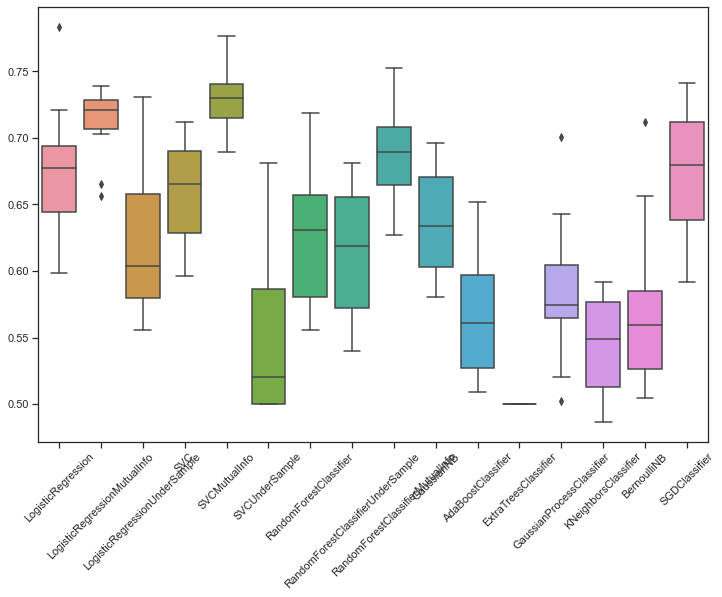

In [687]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'LogisticRegression': scores_lr})
scores_df['LogisticRegressionMutualInfo'] = scores_lr_mutual_info
scores_df['LogisticRegressionUnderSample'] = scores_lr_under_sample

scores_df['SVC'] = scores_svc
scores_df['SVCMutualInfo'] = scores_svc_mutual_info
scores_df['SVCUnderSample'] = scores_svc_under_sample

scores_df['RandomForestClassifier'] = scores_forest
scores_df['RandomForestClassifierUnderSample'] = scores_forest_under_sample
scores_df['RandomForestClassifierMutualInfo'] = scores_forest_mutual_info

scores_df['GaussianNB'] = scores_gnb
scores_df['AdaBoostClassifier'] = scores_abc
scores_df['ExtraTreesClassifier'] = scores_etc
scores_df['GaussianProcessClassifier'] = scores_gpc
scores_df['KNeighborsClassifier'] = scores_knc
scores_df['BernoulliNB'] = scores_bnb
scores_df['SGDClassifier'] = scores_sgd

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

## SGD Shap

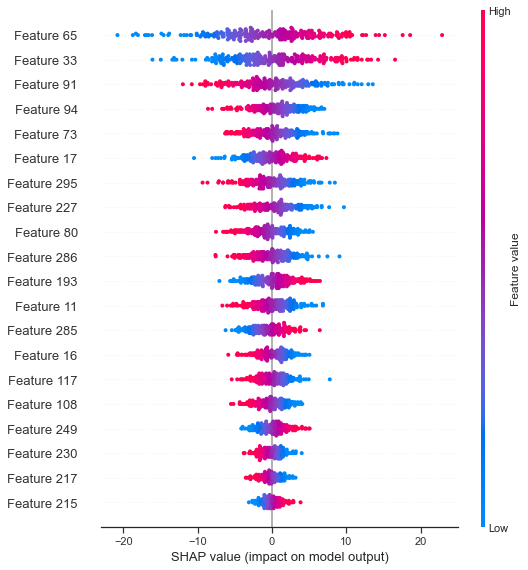

In [690]:
explainer = shap.LinearExplainer(sgd, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [691]:
eli5.show_weights(sgd, top=50)

Weight?,Feature
+7.908,<BIAS>
+7.326,x65
+5.869,x33
+2.945,x17
+2.698,x193
+2.120,x285
+1.897,x249
+1.174,x215
+1.024,x30
+0.973,x78
